# Ringdown Amp Model

This notebook creates the ringdown amp model.

## Steps

0. Configs
    - output dir
    - ansatz
    - fit parameters
1. loads NR data and defines train/test split
2. Fit ansatz to each sample
3. Parameter space fit
4. model validation
5. save model (GPs)

# Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure()
plt.show()
plt.close()
matplotlib.rcParams.update({"font.size": 16})

<Figure size 432x288 with 0 Axes>

In [2]:
import numpy as np
import os
import copy
import datetime
import pandas as pd
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

# gpr fitting
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, RationalQuadratic, Matern, DotProduct

# i tried joblib and dill to save the model but they didn't work
# because under the hood i used a sympy lambdify function
# this SO post solved my issue using cloudpickle.
# https://stackoverflow.com/a/31365136/12840171
import cloudpickle

In [3]:
# custom
import phenom
import workflow_utils
import pn

import collocation

In [4]:
import sympy
# sympy.init_printing()
x_sym, a_sym, om_rd = sympy.symbols('x_sym a_sym om_rd')

# Config

In [5]:
target = 'amp'
region = 'ringdown'

tag = datetime.date.today().strftime("%d_%m_%y")

ROOT_DIR = "/Users/sebastian.khan/personal/data/gpm_model"
OUTPUT_DIR = f"{target}_{region}_{tag}"
OUTPUT_PATH = os.path.join(ROOT_DIR, OUTPUT_DIR)

print(f"{OUTPUT_DIR = }")
print(f"{OUTPUT_PATH = }")

OUTPUT_DIR = 'amp_ringdown_14_07_23'
OUTPUT_PATH = '/Users/sebastian.khan/personal/data/gpm_model/amp_ringdown_14_07_23'


In [75]:
os.makedirs(OUTPUT_PATH, exist_ok=False)

In [7]:
# Time range avaiable to use for fitting and testing
pad = 10
t_start = -10 - pad
t_end = 40 + pad

# can choose to resample or not
# dt = 0.1
dt = None

## DEFINE ANSATZ

base_ansatz = np.sum([sympy.asinh(a_sym * x_sym)**power for power in range(5)])
# base_ansatz = np.sum([sympy.asinh(a_sym * x_sym)**power for power in range(4)])
collocation_points = {
    0:[0, 5, 20, 30],
    1:[0]
}

# Load NR

In [8]:
data_dict = workflow_utils.load_nr_data()

# test_set_query='(q>1 and q<2) or (q>2 and q<=4) or (q>=7 and q<10) or (q>=14 and q<16)'
# data_dict = workflow_utils.load_nr_data(test_set_query=test_set_query)



In [9]:
data_dict['train_idxs']

Int64Index([ 0,  4,  6,  8, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26,
            27, 31, 35, 37, 38, 46, 51, 53],
           dtype='int64')

In [10]:
data_dict['test_idxs']

Int64Index([ 1,  2,  3,  5,  7,  9, 11, 14, 24, 25, 28, 29, 30, 32, 33, 34, 36,
            39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 52],
           dtype='int64')

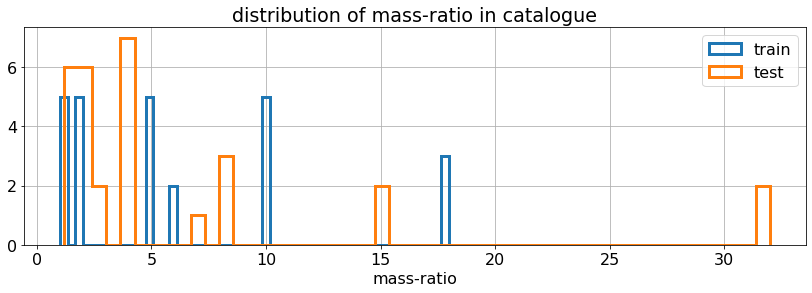

In [11]:
plt.figure(figsize=(14, 4))
plt.hist(data_dict['df']['q'][data_dict['train_idxs']], bins=50, histtype='step', lw=3, label='train')
plt.hist(data_dict['df']['q'][data_dict['test_idxs']], bins=50, histtype='step', lw=3, label='test')
plt.legend()
plt.xlabel("mass-ratio");
plt.title("distribution of mass-ratio in catalogue")
plt.grid()

In [12]:
waveforms = [
    workflow_utils.Waveform(
        strain=data_dict['strains'][i],
        times=data_dict['times'],
        amp=data_dict['amps'][i],
        phase=data_dict['phases'][i],
        freq=data_dict['freqs'][i],
        q=data_dict['df']['q'].values[i],
        meta_data=data_dict['df'].loc[[i]],
    )
    for i in range(len(data_dict['df']))]

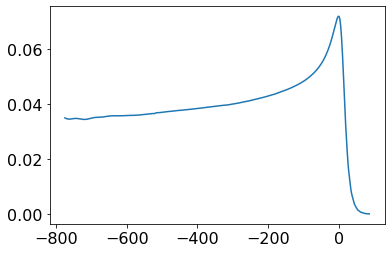

In [13]:
plt.plot(waveforms[0].times, waveforms[0].amp)

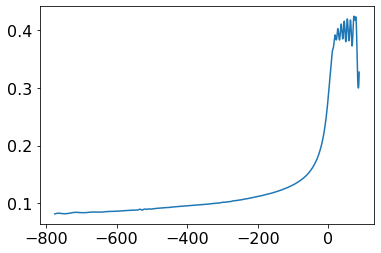

In [14]:
plt.plot(waveforms[0].times, waveforms[0].freq)

# Fit ansatz

In [15]:
# wcfs: Waveform Collocation Fitter objects
wcfs = []

for i in range(len(data_dict['df'])):
    q = data_dict['df'].iloc[i]['q']
    name = data_dict['df'].iloc[i]['name']
    set_member = data_dict['df'].iloc[i]['set']
    print(f"working: {i} ({set_member}): q={q} \t {name}")
    
    eta = phenom.eta_from_q(q)
    ang_fdamp = data_dict['df'].iloc[i]['fdamp']*2*np.pi
    
    # get data to fit
    t_, y_ = workflow_utils.prepare_fit_data(
        waveform=waveforms[i],
        t_start=t_start,
        t_end=t_end,
        target=target,
        dt=dt,
    )
    
    # apply tranformation
    y_transformed = workflow_utils.transformation_affine_reverse(y_, eta)
    # y_transformed = workflow_utils.transformation_affine_reverse(y_)
    
    # prepare ansatz
    ansatz = base_ansatz.copy()
    sub_dict = {"a_sym":ang_fdamp}
    
    wcf = workflow_utils.WaveformCollocationFitter(
        t_,
        y_transformed,
        collocation_points,
        ansatz,
        sub_dict,
    )

    wcfs.append(wcf)

working: 0 (train): q=18.0 	 q18a0a0c025_96_fine
working: 1 (test): q=4.0 	 q4a0_T_96_384
working: 2 (test): q=8.0 	 q8a0a0_T_96_504n512
working: 3 (test): q=8.0 	 q8a0a0c05_T_80_420
working: 4 (train): q=10.0 	 q10c25e_T_112_448
working: 5 (test): q=4.0 	 q4a0_T_80_320
working: 6 (train): q=18.0 	 q18a0a0c025_144
working: 7 (test): q=8.0 	 q8a0a0_T_112_588n768
working: 8 (train): q=18.0 	 q18a0a0c025_120
working: 9 (test): q=4.0 	 q4a0_T_112_448
working: 10 (train): q=5.0 	 SXS_BBH_0107_Res3
working: 11 (test): q=4.0 	 SXS_BBH_0167_Res5
working: 12 (train): q=5.0 	 SXS_BBH_0107_Res5
working: 13 (train): q=5.0 	 SXS_BBH_0107_Res4
working: 14 (test): q=4.0 	 SXS_BBH_0167_Res3
working: 15 (train): q=2.0 	 SXS_BBH_0169_Res4
working: 16 (train): q=2.0 	 SXS_BBH_0169_Res5
working: 17 (train): q=2.0 	 SXS_BBH_0169_Res3
working: 18 (train): q=1.0 	 SXS_BBH_0180_Res3
working: 19 (train): q=10.0 	 SXS_BBH_0303_Res3
working: 20 (train): q=1.0 	 SXS_BBH_0180_Res2
working: 21 (train): q=10.0 	 SXS

In [16]:
titles_ = []
y0s_ = []
y1s_ = []
pns_ = []
for i in range(len(data_dict['df'])):
    title_ = data_dict['df']['tag'][i]
    q = data_dict['df']['q'][i]
    eta = phenom.eta_from_q(q)
    y0_ = workflow_utils.transformation_affine_foward(wcfs[i].y, eta)
    y1_ = workflow_utils.transformation_affine_foward(wcfs[i].cm.predict(wcfs[i].x), eta)
    
    titles_.append(title_)
    y0s_.append(y0_)
    y1s_.append(y1_)

y0s_ = np.array(y0s_)
y1s_ = np.array(y1s_)


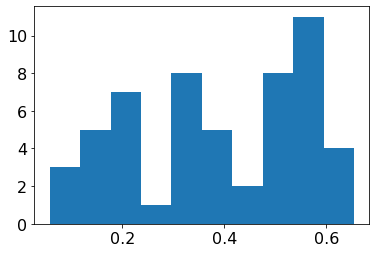

In [17]:
plt.hist(np.max(np.abs(y0s_ - y1s_), 1));

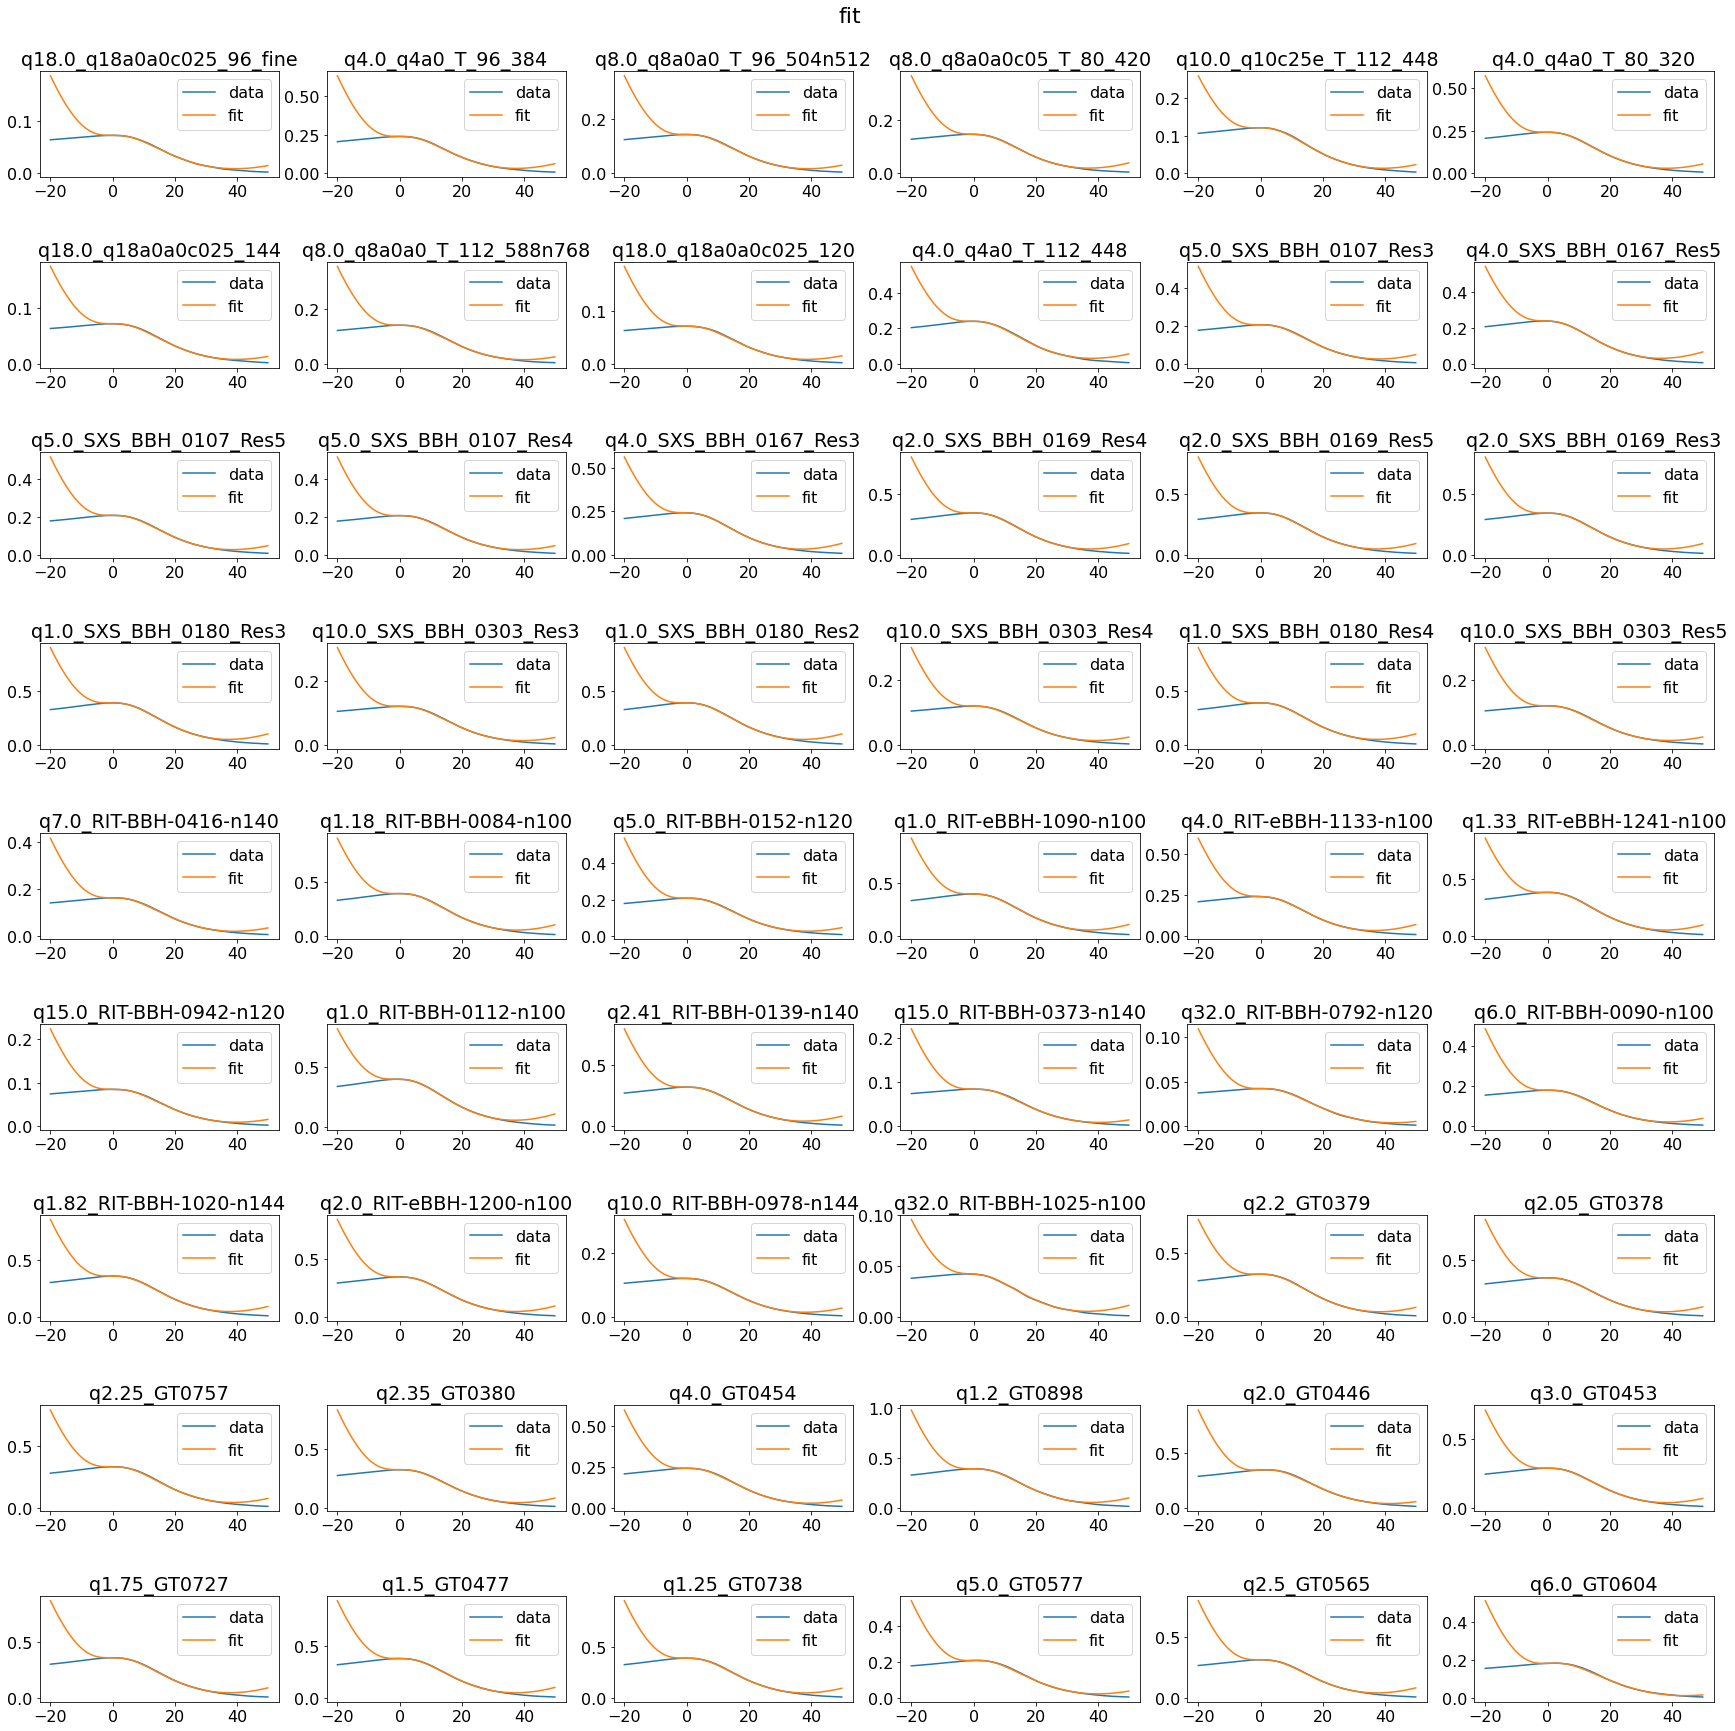

In [18]:
workflow_utils.plot_grid(xs=wcfs[0].x, ys=np.array([y0s_, y1s_]), ncols=6, figsize=(30, 30), titles=titles_, label=['data','fit'], suptitle="fit")

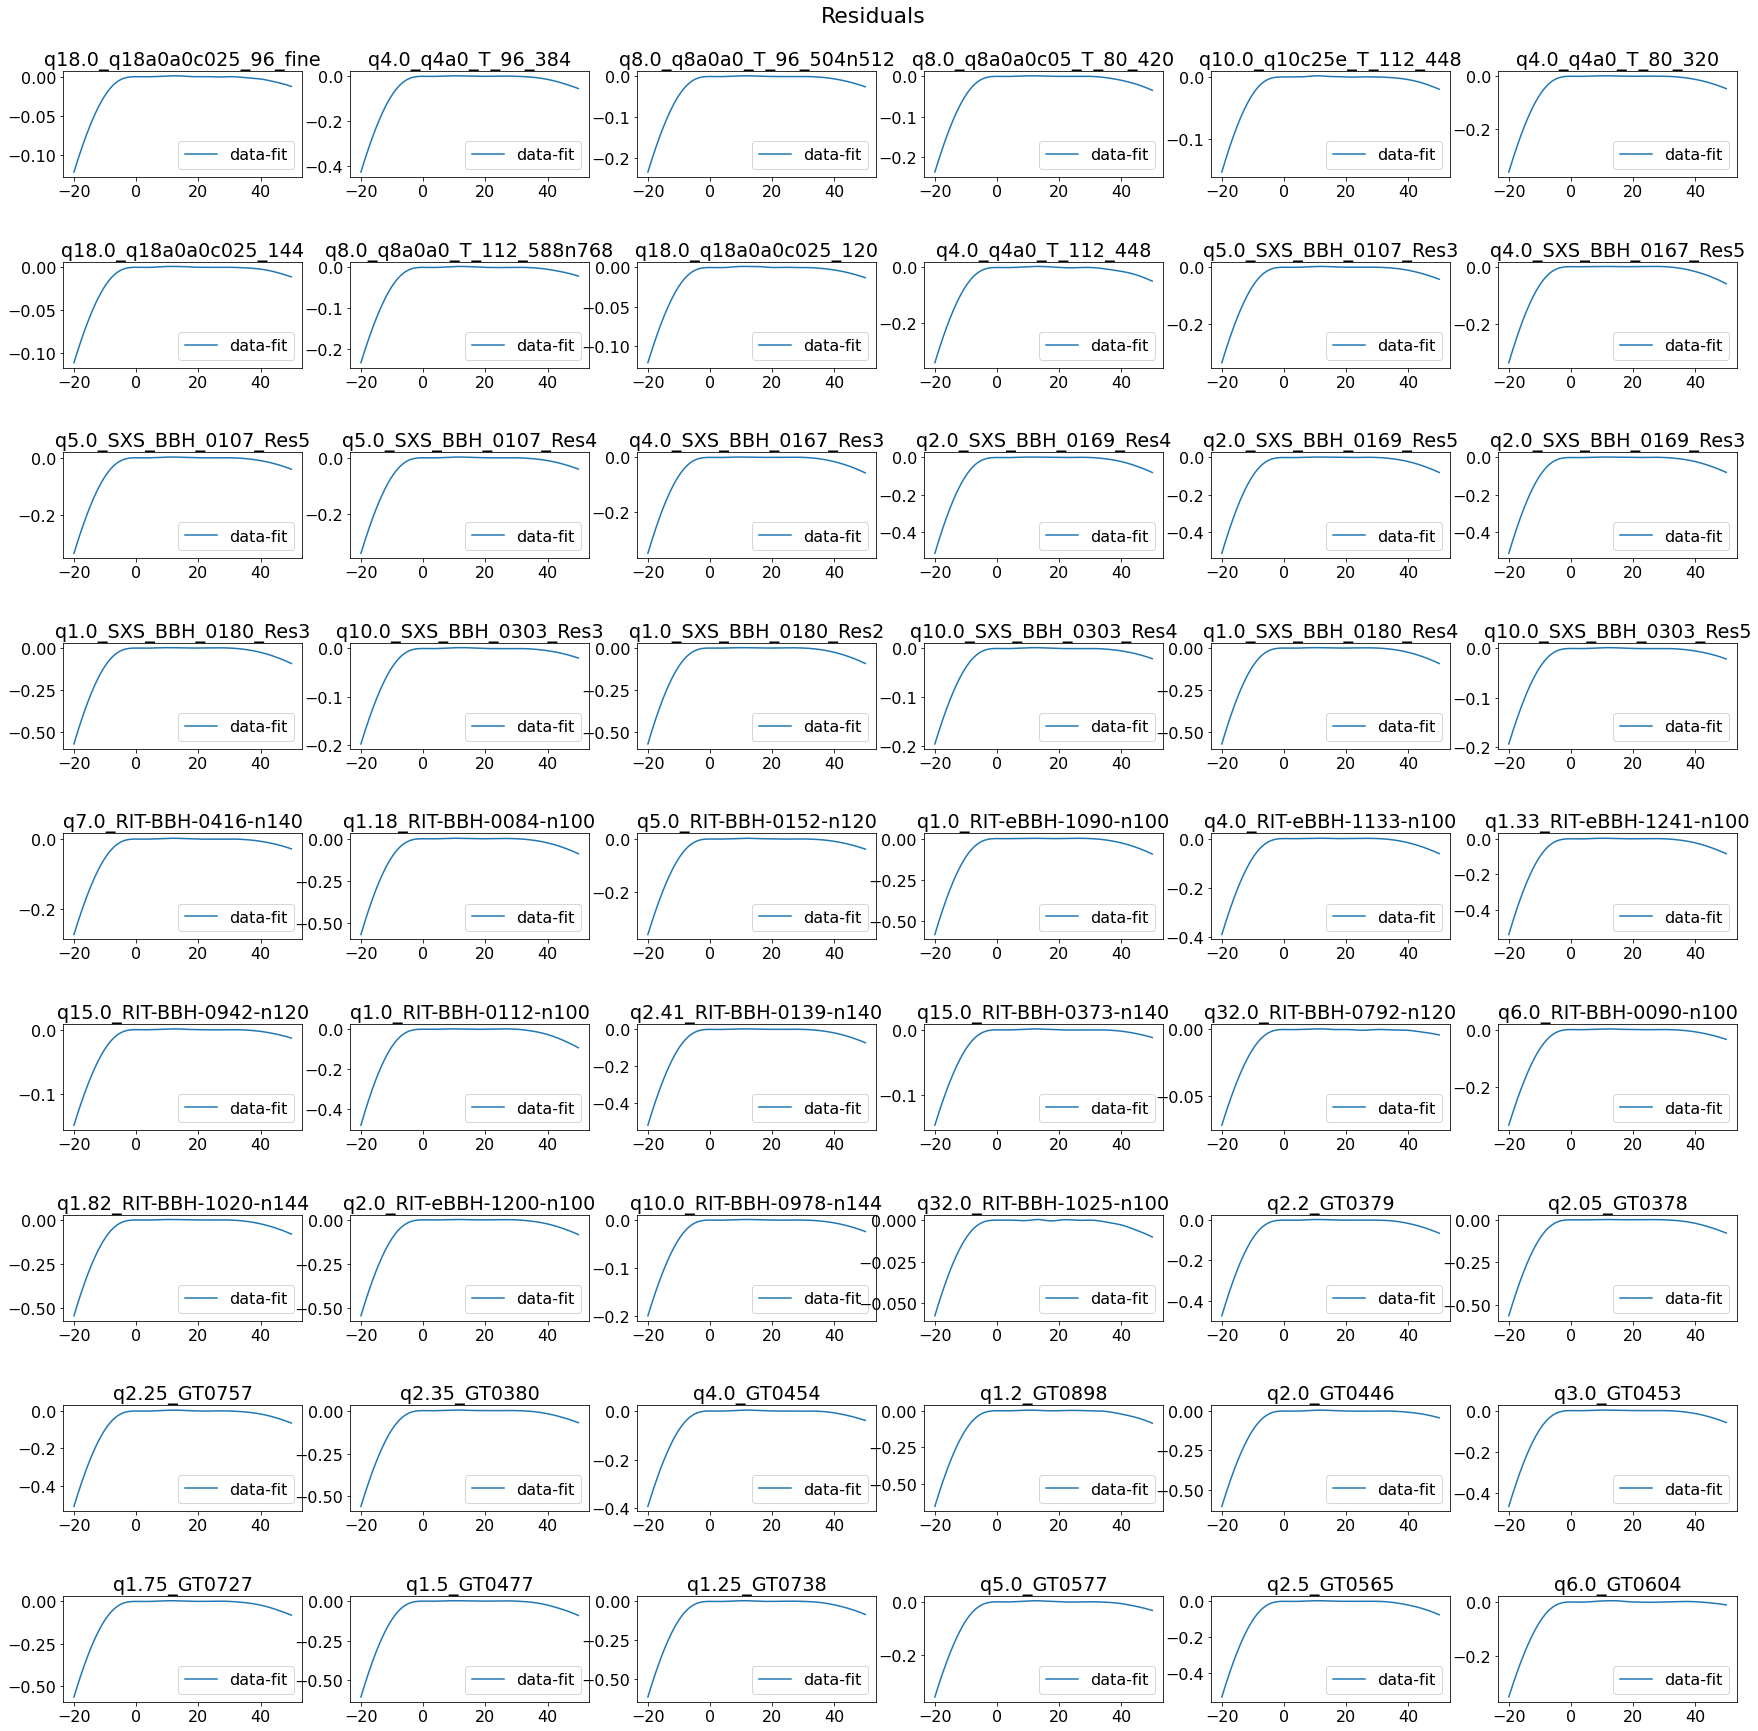

In [19]:
workflow_utils.plot_grid(xs=wcfs[0].x, ys=np.array([y0s_ - y1s_]), ncols=6, figsize=(30, 30), titles=titles_, label=['data-fit'], suptitle="Residuals")

# parameter space fits

## build train/test set for parameter space fits

In [20]:
# use these as the column names
# for the train/test set dataframes
# they correspond to the derivative-order
# and collocation point
tags = wcfs[0].cm.tags
tags

['d0_c0', 'd0_c1', 'd0_c2', 'd0_c3', 'd1_c0']

In [21]:
df_psf_x = data_dict['df']['q']

In [22]:
df_psf_y = pd.DataFrame(np.array([w.cm.rhs_1d for w in wcfs]), columns=tags)

In [23]:
df_psf_x_train = df_psf_x.iloc[data_dict['train_idxs']]
df_psf_y_train = df_psf_y.iloc[data_dict['train_idxs']]

In [24]:
df_psf_x_test = df_psf_x.iloc[data_dict['test_idxs']]
df_psf_y_test = df_psf_y.iloc[data_dict['test_idxs']]

In [25]:
df_psf_y

d0_c0     d0_c1     d0_c2     d0_c3     d1_c0
0   1.444595  1.396521  0.653283  0.283492  0.000087
1   1.493629  1.441034  0.648345  0.276957  0.000088
2   1.449147  1.396845  0.641038  0.273292 -0.000084
3   1.469271  1.399173  0.610814  0.262574 -0.002832
4   1.464171  1.399635  0.629234  0.268040 -0.000081
5   1.508777  1.448102  0.652280  0.279779 -0.000143
6   1.445707  1.391995  0.645352  0.275510 -0.000320
7   1.428094  1.379505  0.646513  0.277204 -0.000030
8   1.439448  1.387580  0.637817  0.273604 -0.000506
9   1.495244  1.428887  0.643837  0.283630 -0.001122
10  1.489998  1.433879  0.646972  0.277435  0.000107
11  1.498725  1.412300  0.594305  0.254036 -0.004307
12  1.489317  1.434835  0.654969  0.282225  0.000130
13  1.488899  1.435820  0.657329  0.283538  0.000304
14  1.499503  1.422725  0.611779  0.261684 -0.002792
15  1.550829  1.486449  0.663593  0.290592 -0.000131
16  1.550842  1.486402  0.663512  0.290518 -0.000142
17  1.550815  1.486991  0.664487  0.291057 -0.000095
18  1.572519  1.507731  0.678829  0.300473 -0.000121
19  1.457228  1.407181  0.654874  0.281388  0.000162
20  1.572589  1.507772  0.678942  0.300445 -0.000125
21  1.457007  1.402659  0.645593  0.276929 -0.000527
22  1.572556  1.507749  0.678776  0.300497 -0.000121
23  1.457160  1.400793  0.641618  0.274958 -0.000797
24  1.475138  1.424248  0.658262  0.280776 -0.000092
25  1.573359  1.509426  0.683767  0.303213 -0.000115
26  1.494523  1.445624  0.668639  0.286143  0.000448
27  1.573249  1.505556  0.676016  0.299641 -0.000991
28  1.500955  1.420425  0.605728  0.258190 -0.004581
29  1.568612  1.503743  0.680938  0.301407  0.000032
30  1.449115  1.402657  0.658031  0.279399 -0.000138
31  1.579155  1.495435  0.652773  0.288743 -0.002465
32  1.540557  1.482728  0.669600  0.291446  0.000144
33  1.445647  1.400922  0.662730  0.280856  0.000077
34  1.441441  1.402111  0.696190  0.305458  0.000067
35  1.477889  1.430878  0.662874  0.282748  0.000040
36  1.557549  1.496420  0.675831  0.296183  0.000087
37  1.551157  1.484663  0.661339  0.289627 -0.001258
38  1.459750  1.397940  0.626864  0.266166 -0.001872
39  1.432679  1.341897  0.566596  0.247112 -0.006282
40  1.555757  1.492890  0.675711  0.292294  0.000189
41  1.559797  1.501803  0.679596  0.295703  0.000142
42  1.557968  1.499510  0.690642  0.301968  0.000062
43  1.548890  1.493567  0.681906  0.295382 -0.000162
44  1.515107  1.460553  0.676100  0.286977 -0.000250
45  1.582784  1.526747  0.705029  0.309405 -0.000107
46  1.560277  1.540787  0.776528  0.344007  0.005677
47  1.538255  1.481397  0.673994  0.289709  0.000114
48  1.572229  1.511415  0.687729  0.303783 -0.000073
49  1.576015  1.515242  0.684164  0.301101 -0.000106
50  1.583682  1.525311  0.702443  0.310410  0.000004
51  1.509346  1.473027  0.705232  0.306325  0.002886
52  1.546648  1.488906  0.671993  0.293489 -0.000089
53  1.493203  1.483079  0.772560  0.336726  0.004894

In [26]:
# fix by hand the derivative
df_psf_y_train['d1_c0'] = np.abs(df_psf_y_train['d1_c0'])

/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_34564/1092029793.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_psf_y_train['d1_c0'] = np.abs(df_psf_y_train['d1_c0'])


/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


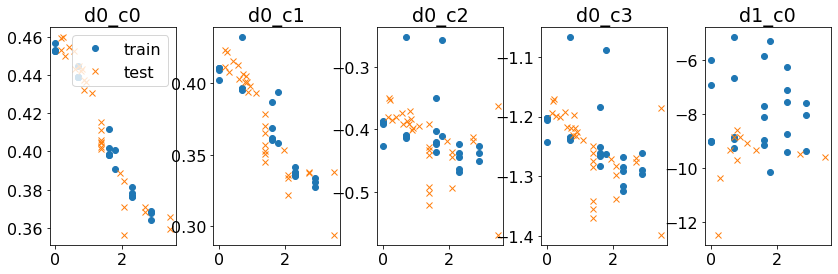

In [27]:
cols = df_psf_y_train.columns
ncols = len(cols)
nsamples = len(cols)
nrows = workflow_utils.get_nrows(ncols, nsamples)

plt.figure(figsize=(14, 4))
plt.subplots_adjust(hspace=0.8, wspace=0.3)
for i in range(nsamples):
    col = cols[i]
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.plot(np.log(df_psf_x_train), np.log(df_psf_y_train[col]), 'o', label='train')
    ax.plot(np.log(df_psf_x_test), np.log(df_psf_y_test[col]), 'x', label='test')
    ax.set_title(col)
    if i == 0:
        ax.legend()

In [28]:
alphas = workflow_utils.compute_alphas(df_psf_x_train, df_psf_y_train)

In [29]:
alphas

{'d0_c0': array([0.00333919, 0.00307326, 0.00333919, 0.00333919, 0.00864405,
        0.00864405, 0.00864405, 0.00419108, 0.00419108, 0.00419108,
        0.00288963, 0.00307326, 0.00288963, 0.00307326, 0.00288963,
        0.00307326, 0.00864405, 0.00288963, 0.00288963, 0.01082832,
        0.00419108, 0.00307326, 0.00419108, 0.00864405, 0.01082832]),
 'd0_c1': array([0.00447093, 0.00354139, 0.00447093, 0.00447093, 0.0165568 ,
        0.0165568 , 0.0165568 , 0.02446065, 0.02446065, 0.02446065,
        0.00534756, 0.00354139, 0.00534756, 0.00354139, 0.00534756,
        0.00354139, 0.0165568 , 0.00534756, 0.00534756, 0.03691158,
        0.02446065, 0.00354139, 0.02446065, 0.0165568 , 0.03691158]),
 'd0_c2': array([0.00773386, 0.01165052, 0.00773386, 0.00773386, 0.02292957,
        0.02292957, 0.02292957, 0.05068058, 0.05068058, 0.05068058,
        0.011411  , 0.01165052, 0.011411  , 0.01165052, 0.011411  ,
        0.01165052, 0.02292957, 0.011411  , 0.011411  , 0.07755987,
        0.0506805

In [30]:
# we need to store the sign of the data so that
# we can reverse a log(abs(x)) transformation
signs_dict = df_psf_y_train.apply(lambda x: np.sign(x)).iloc[[0]]
signs_dict

d0_c0  d0_c1  d0_c2  d0_c3  d1_c0
0    1.0    1.0    1.0    1.0    1.0

In [53]:
# loop over a fit
gps={}
for col in df_psf_y_train.columns:
    print(f"working: {col}")
    GaussianProcessRegressor_kwargs=dict(
        # kernel=Matern(nu=2.5) * ConstantKernel() + DotProduct() * ConstantKernel(),
        kernel=RBF(),
        alpha=alphas[col]/10,
        random_state=0,
        # normalize_y=True,
        normalize_y=False,
        n_restarts_optimizer=100,
        # optimizer=None
    )
    
    # transformations
    # x -> log(x)
    # y -> log(sign(y) * y)
    # for y we first enforce that the target is positive and then we take the log
    x=df_psf_x_train.apply(lambda x: np.log(x)).values
    y=df_psf_y_train[col].apply(lambda x: np.log(signs_dict[col].values * x)).values
    gp = workflow_utils.gpr_fit(
        x=x,
        y=y,
        GaussianProcessRegressor_kwargs=GaussianProcessRegressor_kwargs,
    )
    gps[col] = gp

working: d0_c0
working: d0_c1
working: d0_c2
working: d0_c3
working: d1_c0


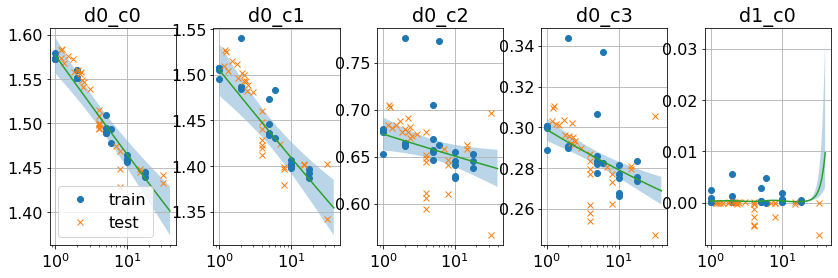

In [54]:
qs_fine = np.arange(1, 40, 0.5)[:,np.newaxis]
cols = df_psf_y_train.columns
ncols = len(cols)
nsamples = len(cols)
nrows = workflow_utils.get_nrows(ncols, nsamples)

plt.figure(figsize=(14, 4))
plt.subplots_adjust(hspace=0.8, wspace=0.3)
for i in range(nsamples):
    col = cols[i]
    gp = gps[col]
    
    # generate samples and reverse transformation
    mu_samples = gp.sample_y(np.log(qs_fine), n_samples=100, random_state=0)
    mu_samples = signs_dict[col].values * np.exp(mu_samples)
    mu_test, std_test = gp.predict(np.log(qs_fine), return_std=True)
    mu_test_lower = signs_dict[col].values * np.exp(mu_test-2*std_test)
    mu_test_upper = signs_dict[col].values * np.exp(mu_test+2*std_test)
    mu_test = signs_dict[col].values * np.exp(mu_test)
    
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.plot(df_psf_x_train, df_psf_y_train[col], 'o', label='train')
    ax.plot(df_psf_x_test, df_psf_y_test[col], 'x', label='test')
    ax.plot(qs_fine, mu_test)
    # ax.plot(qs_fine, mu_samples, alpha=0.1, c='k')
    ax.fill_between(qs_fine[:,0], y1=mu_test_lower, y2=mu_test_upper, alpha=0.3)
    
    ax.set_title(col)
    if i == 0:
        ax.legend()
    # plt.axhline(1.5)
    # plt.axvline(32)
    # ax.set_ylim(0,3)
    ax.set_xscale('log')
    ax.grid()
    
plt.show()
plt.close()

# model function

In [55]:
# generative phenomenological model (gpm)
def gpm_ringdown_amp_model(t, q, collocation_points, base_ansatz, gps, signs_dict, n_samples=-1, random_state=None):
    """
    if n_samples = -1 then generate the mean otherwise draw a n_samples
    """
    if random_state == None:
        random_state = np.random.randint(0, 1000000)
    if n_samples == -1:
        mode = "mean"
        n_samples = 1
    else:
        mode = "sample"
    
    t = np.atleast_1d(t)
    eta = phenom.eta_from_q(q)
    log_q = np.log(q)
    
    ang_fdamp = workflow_utils.get_fdamp_from_q(q)*2*np.pi
    
    sub_dict = {'a_sym':ang_fdamp}
    ansatz = base_ansatz.subs(sub_dict)
    
    # number of derivatives
    num_d_points = len(collocation_points.keys())
    # number of collocations points for each derivative
    num_c_points = [len(collocation_points[d]) for d in collocation_points.keys()]
    
    rhs = {}
    ## if mean then use the 'predict' method from the GP
    if mode == "mean":
        for d in range(num_d_points):
            rhs[d] = []
            for c in range(num_c_points[d]):
                tag = f"d{d}_c{c}"
                v = gps[tag].predict([[log_q]])
                v = np.exp(v)
                v = signs_dict[tag].values * v
                rhs[d].append(np.array([v]))
    ## if sample then use the 'sample_y' method from the GP
    elif mode == "sample":
        for d in range(num_d_points):
            rhs[d] = []
            for c in range(num_c_points[d]):
                tag = f"d{d}_c{c}"
                v = gps[tag].sample_y([[log_q]], n_samples, random_state=random_state)
                v = np.exp(v)
                v = signs_dict[tag].values * v
                rhs[d].append(v.T)
    else:
        raise ValueError(f"mode = {mode} unknown")

    # store a copy
    rhs_ = copy.deepcopy(rhs)
    
    yhats = []
    for n in range(n_samples):
        
        # have to extract the rhs for each sample
        for d in rhs_.keys():
            for i in range(len(rhs_[d])):
                rhs[d][i] = rhs_[d][i][n,0]
                
        cm = collocation.CollocationModel(
            collocation_points=collocation_points,
            rhs=rhs,
            ansatz=ansatz,
            sub_dict=None,
        )
        yhat = cm.predict(t)
        yhat = workflow_utils.transformation_affine_foward(yhat, eta)
        yhats.append(yhat)
    
    return np.array(yhats)

# model validation

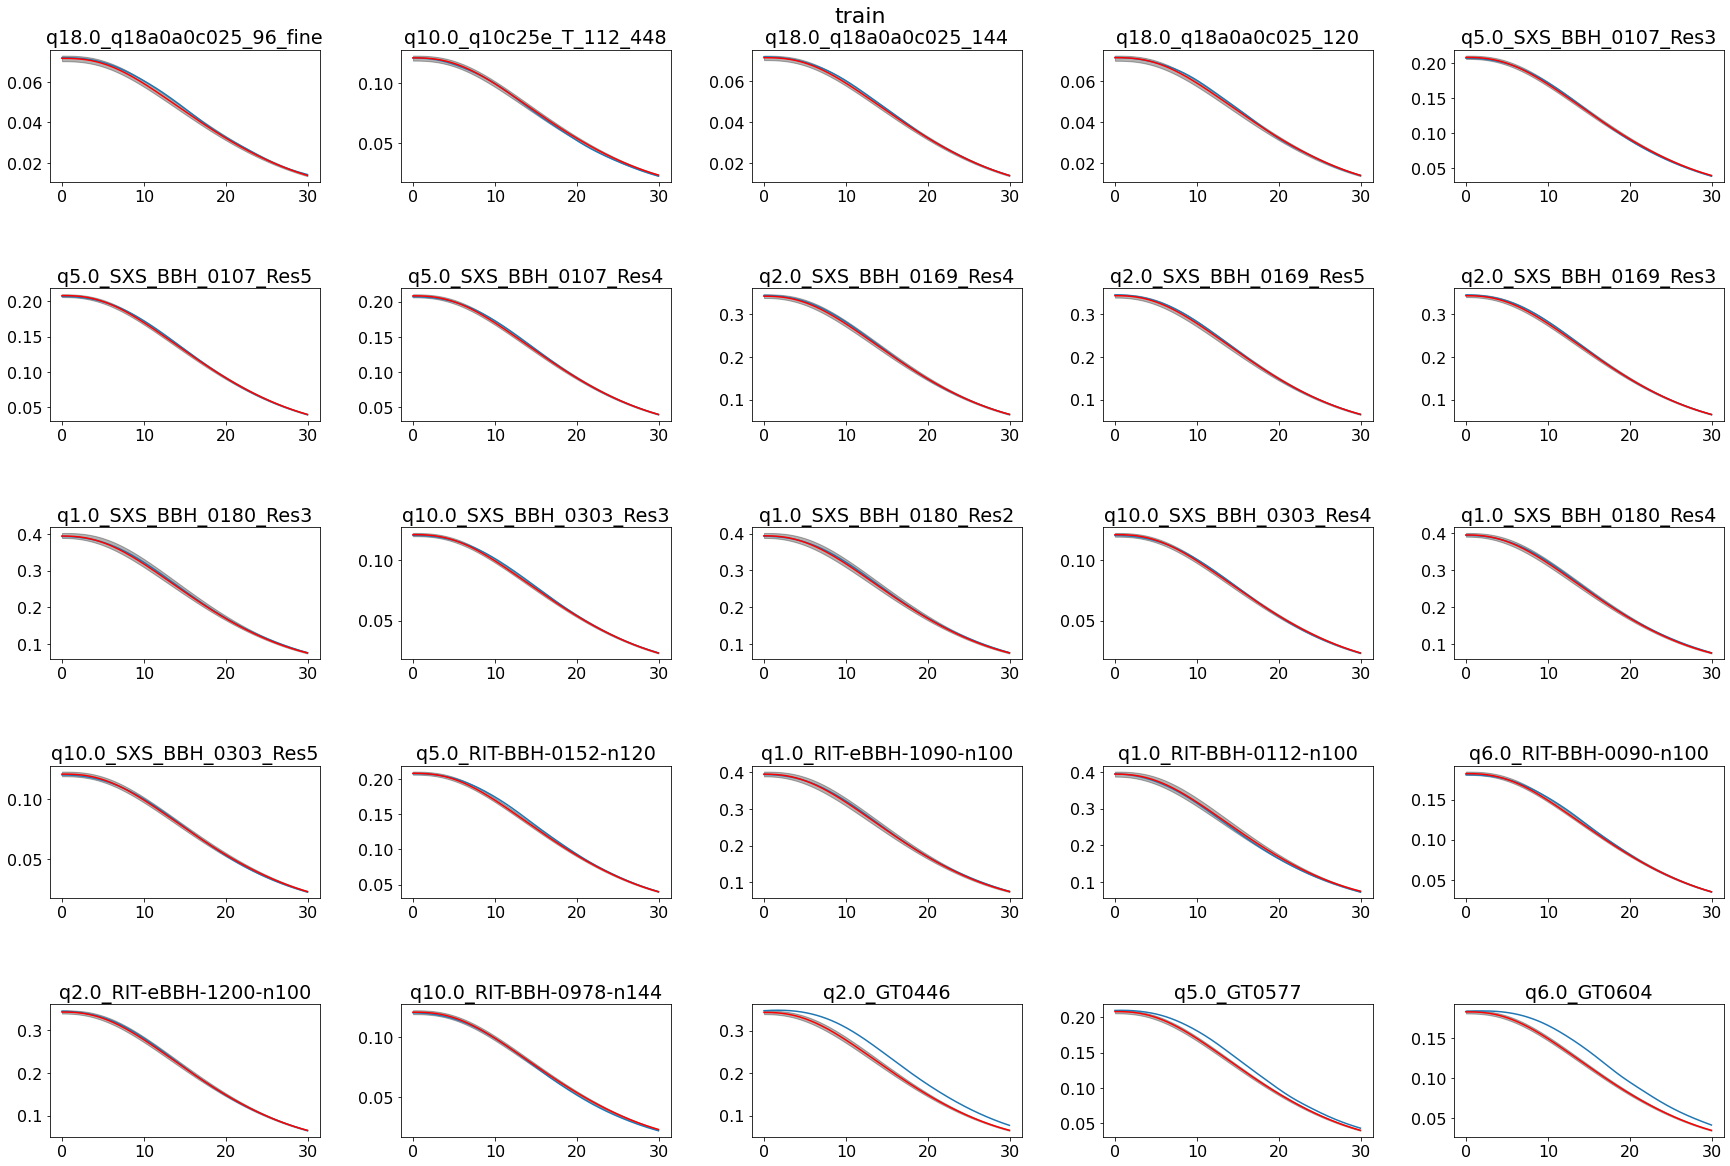

In [56]:
ncols = 5
samples = data_dict['train_idxs']
nsamples = len(samples)
nrows = workflow_utils.get_nrows(ncols, nsamples)

plt.figure(figsize=(30, 20))
plt.subplots_adjust(hspace=0.8, wspace=0.3)
plt.suptitle("train", fontsize=22, y=0.91)
    
for i, idx in enumerate(samples):
    q_star = data_dict['df'].iloc[idx]['q']
    t_star = data_dict['times']
    mask = (t_star >= collocation_points[0][0]) & (t_star <= collocation_points[0][-1])
    t_star = t_star[mask]
    ynr = data_dict['amps'][idx]
    ynr = ynr[mask]
    yhats = gpm_ringdown_amp_model(t_star, q_star, collocation_points, base_ansatz, gps, signs_dict, n_samples=-1)
    yhats_samples = gpm_ringdown_amp_model(t_star, q_star, collocation_points, base_ansatz, gps, signs_dict, n_samples=100)
    
    ydiff_samples = (ynr - yhats_samples)
    
    ax = plt.subplot(nrows, ncols, i + 1)
    # ax.plot(t_star, ynr-yhats[0], c='r')
    # ax.fill_between(t_star, y1=ydiff_samples.min(0), y2=ydiff_samples.max(0), color='k', alpha=0.3)
    # ax.axhline(0, c='C0')

    ax.plot(t_star, ynr)
    ax.plot(t_star, yhats[0], c='r')
    ax.fill_between(t_star, y1=yhats_samples.min(0), y2=yhats_samples.max(0), color='k', alpha=0.3)
    

    
    ax.set_title(data_dict['df'].iloc[idx]['tag'])
    
    # ax.set_ylim(-0.001, 0.001)

plt.show()
plt.close()

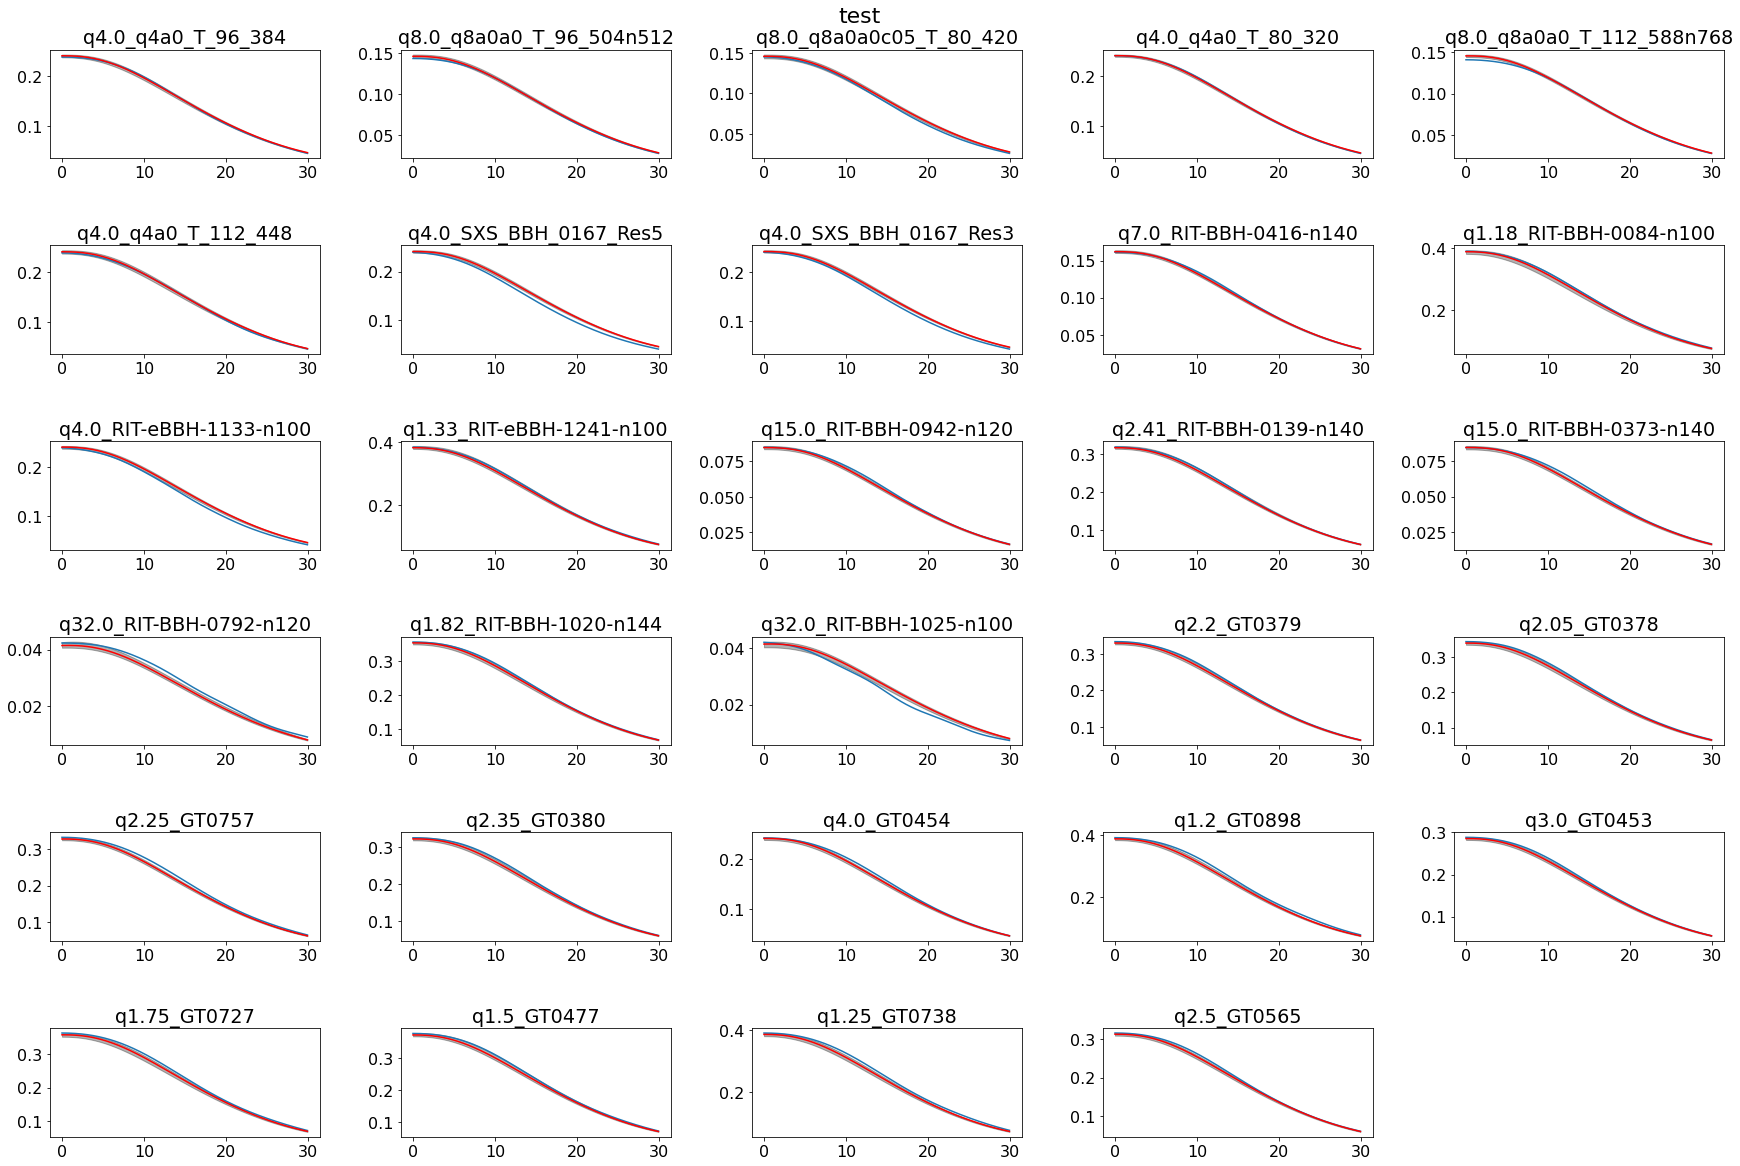

In [57]:
ncols = 5
samples = data_dict['test_idxs']
nsamples = len(samples)
nrows = workflow_utils.get_nrows(ncols, nsamples)

plt.figure(figsize=(30, 20))
plt.subplots_adjust(hspace=0.8, wspace=0.3)
plt.suptitle("test", fontsize=22, y=0.91)

for i, idx in enumerate(samples):
    q_star = data_dict['df'].iloc[idx]['q']
    t_star = data_dict['times']
    mask = (t_star >= collocation_points[0][0]) & (t_star <= collocation_points[0][-1])
    t_star = t_star[mask]
    ynr = data_dict['amps'][idx]
    ynr = ynr[mask]
    yhats = gpm_ringdown_amp_model(t_star, q_star, collocation_points, base_ansatz, gps, signs_dict, n_samples=-1)
    yhats_samples = gpm_ringdown_amp_model(t_star, q_star, collocation_points, base_ansatz, gps, signs_dict, n_samples=100)
    
    ydiff_samples = (ynr - yhats_samples)
    
    ax = plt.subplot(nrows, ncols, i + 1)
    # ax.plot(t_star, ynr-yhats[0], c='r')
    # ax.fill_between(t_star, y1=ydiff_samples.min(0), y2=ydiff_samples.max(0), color='k', alpha=0.3)
    # ax.axhline(0, c='C0')
    
    ax.plot(t_star, ynr)
    ax.plot(t_star, yhats[0], c='r')
    ax.fill_between(t_star, y1=yhats_samples.min(0), y2=yhats_samples.max(0), color='k', alpha=0.3)
    
    ax.set_title(data_dict['df'].iloc[idx]['tag'])
    
    # ax.set_ylim(-0.001, 0.001)
plt.show()
plt.close()

# save model

In [58]:
components_to_save = {
    "collocation_points":collocation_points,
    "base_ansatz":base_ansatz,
    "gps":gps,
    "signs_dict":signs_dict,
}

In [59]:
output_filename = os.path.join(OUTPUT_PATH, 'components.cpkl')

In [60]:
output_filename

'/Users/sebastian.khan/personal/data/gpm_model/amp_ringdown_14_07_23/components.cpkl'

In [76]:
with open(output_filename, "wb") as f:
    cloudpickle.dump(components_to_save, f)

In [62]:
# with open(output_filename, 'rb') as f:
#     test_c = cloudpickle.load(f)

In [63]:
# test_c.keys()

In [64]:
# collocation_points = test_c["collocation_points"]
# base_ansatz = test_c["base_ansatz"]
# gps = test_c["gps"]
# signs_dict = test_c["signs_dict"]

In [65]:
data_dict['df'].query('q==18')

name     q     fring    fdamp  duration  t_final  \
0  q18a0a0c025_96_fine  18.0  0.063334  0.01414    1020.0    465.8   
6      q18a0a0c025_144  18.0  0.063334  0.01414    1028.3     88.8   
8      q18a0a0c025_120  18.0  0.063334  0.01414    1027.5    174.7   

   start_freq_100Msun    set  has_dup                        tag  
0           26.412409  train     True  q18.0_q18a0a0c025_96_fine  
6           26.822393  train     True      q18.0_q18a0a0c025_144  
8           26.803431  train     True      q18.0_q18a0a0c025_120

In [66]:
collocation_points

{0: [0, 5, 20, 30], 1: [0]}

In [67]:
t_star = np.arange(-10, 40, 1)
# q_star = 32

# idx = 34
idx = 8
# idx = 22
# idx = 7
# idx = 33
q_star = data_dict['df']['q'][idx]

In [68]:
q_star

18.0

In [69]:
yhats = gpm_ringdown_amp_model(t_star, q_star, collocation_points, base_ansatz, gps, signs_dict, n_samples=-1)
yhats_samples = gpm_ringdown_amp_model(t_star, q_star, collocation_points, base_ansatz, gps, signs_dict, n_samples=100)

In [70]:
yhats.shape

(1, 50)

In [71]:
data_dict['df'].iloc[idx]['q']

18.0

In [72]:
t_start

-20

In [73]:
collocation_points

{0: [0, 5, 20, 30], 1: [0]}

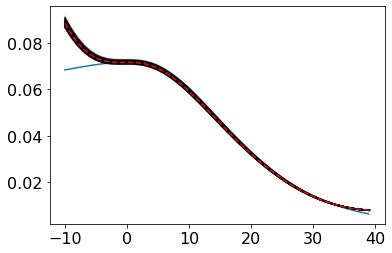

In [74]:
mask = (waveforms[idx].times > t_star[0]) & (waveforms[idx].times < t_star[-1])
plt.plot(waveforms[idx].times[mask], waveforms[idx].amp[mask], label='data')

plt.plot(t_star, yhats_samples.T, c='k', alpha=0.2);
plt.plot(t_star, yhats[0], c='r', ls='--')



# plt.yscale('log')
# plt.xlim(-800, -100)
# plt.ylim(0.05, 0.3)